Необходимо собрать информацию о вакансиях на вводимую должность (используем input или через аргументы) с сайта superjob.ru и hh.ru. Приложение должно анализировать несколько страниц сайта(также вводим через input или аргументы). Получившийся список должен содержать в себе минимум:

    *Наименование вакансии
    *Предлагаемую зарплату (отдельно мин. и отдельно макс.)
    *Ссылку на саму вакансию        
    *Сайт откуда собрана вакансия
По своему желанию можно добавить еще работодателя и расположение. Данная структура должна быть одинаковая для вакансий с обоих сайтов. Общий результат можно вывести с помощью dataFrame через pandas.

**Здесь укажем искомую вакансию**

In [53]:
VAC_NAME = 'Менеджер по продукту'

**Основной алгоритм**

In [49]:
from bs4 import BeautifulSoup
import requests
from pprint import pprint
import lxml as lxml
import numpy as np
import pandas as pd
import re

*HH.ru*

In [50]:
def get_vacancy_HH(vacant_list, vacansy_name):
    
    VAC_NAME = vacansy_name.replace(' ', '+')
    SOURCE_HH = 'https://hh.ru'
    MAIN_LINK = 'https://hh.ru/search/vacancy?st=searchVacancy&L_profession_id=4.1&area=1&no_magic=true'
    header = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.108 Safari/537.36'}
    url = MAIN_LINK + '&text=' + VAC_NAME
    
    next_url = url

    while next_url != '':

        response = requests.get(next_url, headers = header)

        if response.ok:


            html = BeautifulSoup(response.text, 'lxml')
            vacs = html.find_all("div", attrs={ "data-qa" : "vacancy-serp__vacancy"})

            for vac in vacs:
                list_el = {}

                #general info
                tags = vac.find("a", attrs = {"class" : "bloko-link HH-LinkModifier"})
                list_el['url'] = tags['href']
                list_el['caption'] = tags.text
                list_el['sourse'] = 'hh.ru'

                #краткое описание
                descr_path = vac.find('div', attrs = {'data-qa':'vacancy-serp__vacancy_snippet_responsibility'})
                list_el['description'] = descr_path.text

                #salary info
                list_el['salary_from'] = 'n/a'
                list_el['salary_to'] = 'n/a'
                list_el['currensy'] = 'n/a'

                salary_path = vac.find("div", attrs = {"class" : "vacancy-serp-item__compensation"})

                if salary_path: #зарплата указана

                    salary_text = salary_path.text

                    list_el['currensy'] = salary_text.split(' ')[-1][:3]

                    if salary_text[:2] == 'от': #указана только минимальная зп
                        list_el['salary_from'] = salary_text.split(' ')[1].replace('\xa0','')
                    else:
                        if salary_text[:2] == 'до':#указана только максимальная зп
                            list_el['salary_from'] = salary_text.split(' ')[1].replace('\xa0','')
                        else: #указана вилка
                            list_el['salary_from'] = salary_text.split(' ')[0].split('-')[0].replace('\xa0','')
                            list_el['salary_to'] = salary_text.split(' ')[0].split('-')[1].replace('\xa0','')
                #инфо о городе
                city_path = vac.find("span", attrs = {"data-qa":"vacancy-serp__vacancy-address"})

                if city_path:
                    list_el['city'] = city_path.text

                #инфо о работодателе
                employer_path = vac.find("a", attrs = {"data-qa":"vacancy-serp__vacancy-employer"})

                list_el['employer_url'] = 'n/a'
                list_el['employer'] = 'n/a'

                if employer_path:
                    list_el['employer_url'] = SOURCE_HH + employer_path['href']
                    list_el['employer'] = employer_path.text

                vacant_list.append(list_el)

        else:
            print(response)
            break

        next_url = ''

        next_url_path = html.find("a", {"class":"bloko-button HH-Pager-Controls-Next HH-Pager-Control"})

        if next_url_path:
            next_url = SOURCE_HH + next_url_path['href']


*SuperJob.ru*

In [51]:
def get_vacancy_SJ(vacant_list, vacansy_name):
    
    VAC_NAME = vacansy_name.replace(' ', '+')
    SOURCE_SJ = 'https://superjob.ru'
    MAIN_LINK = 'https://superjob.ru/vacancy/search/'
    header = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.108 Safari/537.36'}
    
    url = MAIN_LINK + '?keywords=' + VAC_NAME
    
    next_url = url
    
    while next_url != '':
    
        response = requests.get(next_url, headers = header)

        if response.ok:

            html = BeautifulSoup(response.text, 'lxml')
            vacs = html.find_all("div", {"class" : "_3zucV _2GPIV f-test-vacancy-item i6-sc _3VcZr"})

            for vac in vacs:

                list_el = {}

                general_path = vac.find('div', {"class","_3mfro CuJz5 PlM3e _2JVkc _3LJqf"})
                descr_path = vac.find('div', {"class","_2kyiZ _1cFsi _3VUIu"})
                salary_path = vac.find('span', {"class","_3mfro _2Wp8I f-test-text-company-item-salary PlM3e _2JVkc _2VHxz"})
                city_path = vac.find('span', {"_3mfro f-test-text-company-item-location _9fXTd _2JVkc _2VHxz"})
                employer_path = vac.find('span', {"_3mfro _3Fsn4 f-test-text-vacancy-item-company-name _9fXTd _2JVkc _2VHxz _15msI"})

                #general info
                list_el['url'] = SOURCE_SJ + general_path.parent['href']
                list_el['caption'] = general_path.text
                list_el['sourse'] = SOURCE_SJ

                #краткое описание
                list_el['description'] = descr_path.find('span', {'class':'_3mfro _9fXTd _2JVkc _2VHxz _15msI'}).text

                #salary info
                list_el['salary_from'] = salary_path.text
                list_el['salary_to'] = 'n/a'
                list_el['currensy'] = 'n/a'

                if salary_path: #зарплата указана

                    salary_text = salary_path.text

                    if salary_text != 'По договорённости':

                        list_el['currensy'] = salary_text.split('\xa0')[-1][:1]

                        if salary_text[:2] == 'от': #указана только минимальная зп
                            list_el['salary_from'] = salary_text.split('\xa0')[1] + salary_text.split('\xa0')[2]
                        else:
                            if salary_text[:2] == 'до':#указана только максимальная зп
                                list_el['salary_from'] = salary_text.split('\xa0')[1] + salary_text.split('\xa0')[2]
                            else: #указана вилка или точная зп
                                list_el['salary_from'] = salary_text.split('\xa0')[0] + salary_text.split('\xa0')[1]

                                if len(salary_text.split('\xa0')) > 4:
                                    list_el['salary_to'] = salary_text.split('\xa0')[3] + salary_text.split('\xa0')[4]
                #инфо о городе
                list_el['city'] = city_path.text.split(' • ')[1]

                #инфо о работодателе
                list_el['employer_url'] = 'n/a'
                list_el['employer'] = 'n/a'

                if employer_path:
                    short_emp = employer_path.find('a', {'class':re.compile('icMQ_ _205Zx.*')})
                    list_el['employer_url'] = SOURCE_SJ + short_emp['href']
                    list_el['employer'] = short_emp.text

                vacant_list.append(list_el)

        else:
            print(response)
            break

        next_url = ''

        next_url_path_list = html.find_all("span", {"class":"qTHqo _2h9me DYJ1Y _2FQ5q _2GT-y"})
        next_url_path = next_url_path_list[-1]         
        if next_url_path.text == 'Дальше':
            next_url = SOURCE_SJ + next_url_path.parent['href']

*Поиск вакансий*

In [54]:
vacant_list = list()

get_vacancy_HH(vacant_list, VAC_NAME)
get_vacancy_SJ(vacant_list, VAC_NAME)

*Обработка результата*

In [55]:
df = pd.DataFrame(vacant_list)

In [56]:
df['salary_from_n'] = df['salary_from']
df['salary_to_n'] = df['salary_to']

In [57]:
df.loc[(df['salary_from_n'] == 'n/a') | (df['salary_from_n'] == 'По договорённости'), 'salary_from_n'] = '0'
df.loc[(df['salary_to_n'] == 'n/a') | (df['salary_from_n'] == 'По договорённости'), 'salary_to_n'] = '0'

In [58]:
df['salary_from_n'].apply(lambda x: int(x))
df['salary_to_n'].apply(lambda x: int(x))

df['salary_max'] = df[['salary_from_n','salary_to_n']].max(axis =1)

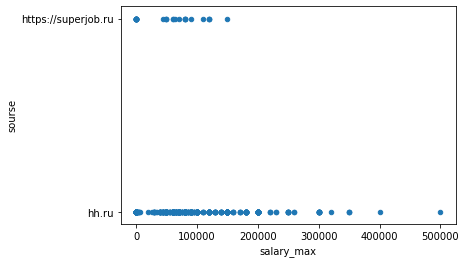

In [59]:
df.plot.scatter('salary_max', 'sourse')

In [60]:
df

,url,caption,sourse,description,salary_from,salary_to,currensy,city,employer_url,employer,salary_from_n,salary_to_n,salary_max
0,https://tver.hh.ru/vacancy/35720879?query=%D0%...,Менеджер по продукту (Product manager),hh.ru,Участвовать в определении и реализации стратег...,180000,n/a,руб,Москва,https://hh.ru/employer/2536,SPN,180000,0,180000.0
1,https://tver.hh.ru/vacancy/35361526?query=%D0%...,Менеджер по продукту (бренд-менеджер),hh.ru,1. Анализ рынка продукции. 2. Ценообразование ...,100000,160000,руб,"Москва, Юго-Западная",https://hh.ru/employer/2377544,ООО ЭмВиАй Рус,100000,160000,160000.0
2,https://tver.hh.ru/vacancy/34545471?query=%D0%...,Менеджер продукта / Product manager,hh.ru,Находит и оформляет идеи по продукту. Проектир...,n/a,n/a,n/a,"Москва, Дмитровская",https://hh.ru/employer/136929,ivi,0,0,0.0
3,https://tver.hh.ru/vacancy/35260760?query=%D0%...,Product Manager (Категорийный менеджер электро...,hh.ru,Подчинение Операционному Директору. Управление...,135000,160000,руб,"Москва, Кунцевская",https://hh.ru/employer/570444,Вартон,135000,160000,160000.0
4,https://tver.hh.ru/vacancy/35653060?query=%D0%...,Product manager / Менеджер по продукту (e-comm...,hh.ru,Оптимизировать существующий продуктовый портфе...,1000,n/a,EUR,Москва,https://hh.ru/employer/3911039,Resultat GmbH,1000,0,1000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1493,https://superjob.ru/vakansii/prodakt-menedzher...,Продакт-менеджер,https://superjob.ru,"Должностные обязанности: Разработка , расчёт и...",60000,n/a,₽,Москва,https://superjob.ru/clients/zoogurman-381214.html,ЗООГУРМАН,60000,0,60000.0
1494,https://superjob.ru/vakansii/mladshij-prodakt-...,Младший продакт-менеджер (м. Планерная),https://superjob.ru,Должностные обязанности: Анализ рынка вентиляц...,45000,n/a,₽,"Москва,Планерная",https://superjob.ru/clients/zern-blauberg-grou...,"ООО ""ЗЕРН"" BLAUBERG Group",45000,0,45000.0
1495,https://superjob.ru/vakansii/prodakt-menedzher...,Продакт-менеджер в фармацевтическую компанию,https://superjob.ru,Должностные обязанности: Подготовка целевых пр...,По договорённости,n/a,n/a,"Москва,Таганская, Марксистская",https://superjob.ru/clients/brend-farm-165929....,Бренд-Фарм,0,0,0.0
1496,https://superjob.ru/vakansii/tehnicheskij-kons...,Технический консультант / Product manager,https://superjob.ru,Должностные обязанности: Демонстрация лакокрас...,По договорённости,n/a,n/a,"Москва,Проспект Вернадского, Киевская и ещё 1 ...",https://superjob.ru/clients/paintgroup-3288805...,PaintGroup,0,0,0.0
